In [1]:
import torch

In [2]:
import networkx as nx

%matplotlib inline

In [3]:
import numpy as np

In [4]:
class GINConv(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.linear = torch.nn.Linear(hidden_dim, hidden_dim)


    def forward(self, A, X):
        """
        Params
        ------
            A [nodes x nodes]: adjacency matrix
        
            X [nodes x features]: node features matrix
        
        Returns
        -------
            X' [nodes x features]: updated node features matrix
        """
        X = self.linear(X + A @ X)
        X = torch.nn.functional.relu(X)
        
        return X

/home/matias/.pyenv/versions/3.7.3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


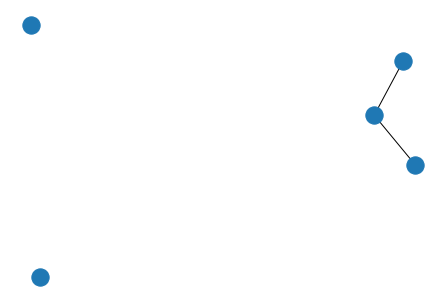

In [5]:
G = nx.binomial_graph(5,0.5)

nx.draw(G)

In [6]:
A = torch.tensor( nx.adjacency_matrix(G).todense(), dtype=torch.float32 )

A

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.]])

In [70]:
X = torch.randn(5,2)

X

tensor([[ 0.1727, -0.2404],
        [-0.4266,  0.0049],
        [-0.8128, -0.1084],
        [ 1.0900,  0.9147],
        [-0.3288,  0.1470]])

In [72]:
GINConv(2).forward(A,X)

tensor([[0.3948, 0.0000],
        [0.7098, 0.0000],
        [0.9193, 0.0000],
        [1.0761, 0.0000],
        [1.2201, 0.0000]], grad_fn=<ReluBackward0>)

In [75]:
torch.cat([X,X],dim=1).sum(dim=0, keepdim=True)

tensor([[-0.3054,  0.7178, -0.3054,  0.7178]])

In [65]:
import torch.utils.data

import importlib  
gnns = importlib.import_module('powerful-gnns.util')

class GraphDataset(torch.utils.data.Dataset):
    """ Levanta los datasets de Powerful-GNNS. """
    
    def __init__(self, dataset='PROTEINS', degree_as_tag=False):
        self.data = gnns.load_data(dataset, degree_as_tag)[0]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = {}
        
        item['node_features'] = self.data[idx].node_features
        item['adjacency_matrix'] = torch.tensor(nx.adjacency_matrix( self.data[idx].g ).todense(), dtype=torch.float32)
        item['class'] = self.data[idx].label
        
        return item

In [108]:
class GNN(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super().__init__()
        
        self.in_proj = torch.nn.Linear(input_dim, hidden_dim)
        
        self.convs = torch.nn.ModuleList()
        
        for _ in range(n_layers):
            self.convs.append(GINConv(hidden_dim))
        
        # In order to perform graph classification, each hidden state
        # [nodes x hidden_dim] is aggregated along nodes dimension,
        # resulting in [hidden_dim], concatenated [hidden_dim x (1+n_layers)]
        # and then fed to the output layer.
        self.out_proj = torch.nn.Linear(hidden_dim*(1+n_layers), output_dim)


    def forward(self, A, X):
        X = self.in_proj(X)

        hidden_states = [X]
        
        for layer in self.convs:
            X = layer(A, X)
            hidden_states.append(X)

        X = torch.cat(hidden_states, dim=2).sum(dim=1)

        X = self.out_proj(X)

        return X

In [109]:
model = GNN(input_dim=3, hidden_dim=2, output_dim=2, n_layers=1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [66]:
ds = GraphDataset()

loading data
# classes: 2
# maximum node tag: 3
# data: 1113


In [96]:
def collate_fn(batch):
    pass

dl = torch.utils.data.DataLoader(ds)

In [110]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dl):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(data['adjacency_matrix'],data['node_features'])
        loss = criterion(outputs, data['class'])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 161.581
[1,    40] loss: 0.545
[1,    60] loss: 0.500
[1,    80] loss: 0.751
[1,   100] loss: 0.516
[1,   120] loss: 0.239
[1,   140] loss: 0.168
[1,   160] loss: 0.037
[1,   180] loss: 0.208
[1,   200] loss: 0.090
[1,   220] loss: 0.169
[1,   240] loss: 0.078
[1,   260] loss: 0.068
[1,   280] loss: 0.011
[1,   300] loss: 0.025
[1,   320] loss: 0.051
[1,   340] loss: 0.088
[1,   360] loss: 0.208
[1,   380] loss: 0.092
[1,   400] loss: 0.146
[1,   420] loss: 0.423
[1,   440] loss: 0.034
[1,   460] loss: 0.242
[1,   480] loss: 0.017
[1,   500] loss: 0.012
[1,   520] loss: 0.090
[1,   540] loss: 0.024
[1,   560] loss: 0.179
[1,   580] loss: 0.061
[1,   600] loss: 0.004
[1,   620] loss: 0.035
[1,   640] loss: 0.012
[1,   660] loss: 0.016
[1,   680] loss: 80.375
[1,   700] loss: 22.443
[1,   720] loss: 1.072
[1,   740] loss: 0.587
[1,   760] loss: 0.545
[1,   780] loss: 0.244
[1,   800] loss: 0.300
[1,   820] loss: 0.278
[1,   840] loss: 0.274
[1,   860] loss: 0.364
[1,   8